Open Health Inspection Analysis
=================

The following notebook explores data produced by the Open Health Inspection app (https://ohi.code4hr.org/) developed by Code for Hampton Roads (http://code4hr.org/). The source data is located at https://ohi-api.code4hr.org/bulk/

Plotly interactive charts will only render 'offline' in Jupyter Notebook therefore static png exports are posted at http://bcbarsness.github.io/ohi-analysis


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# For Notebooks
%matplotlib inline

# For Plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.figure_factory as FF
import cufflinks as cf

# For Plotly in Notebooks
init_notebook_mode(connected=True)
cf.go_offline()

# Plotting config
sns.set(rc={"figure.figsize": (15, 4)})

# Read data
superset = pd.read_json("va_health_inspections_1000.json", lines=True)

################
# Clean & Reduce
################

def getMeanScore(inspections):
    total = 0
    noScoreInspections = 0
    for inspection in inspections:
        try:
            total = inspection['score'] + total
        except: 
            noScoreInspections += 1
            print('.',end='')
    return (total / (len(inspections) - noScoreInspections))

def getDeltaScore(x,y):
    return int(abs(x-y))

reduce = superset.copy()  #reduce footprint but keep orig dataset
reduce = reduce[~np.isnan(superset['score'])]  #remove any records that have no 'score'
reduce['NumInspections'] = reduce['inspections'].apply(lambda x: len(x))
print('Number of inspections without a score: ',end='')
reduce['AvgScore'] = reduce['inspections'].apply(lambda x: getMeanScore(x))
reduce['Delta'] = reduce.apply(lambda x: getDeltaScore(x['AvgScore'],x['score']), axis=1) #refactor
reduce.rename(index=str, columns={'score':'DerivedScore'}, inplace=True)

reduce = reduce[['name', 'category', 'type', 'NumInspections', 'DerivedScore', 'AvgScore', 'Delta']]
byCategory = reduce.groupby('category')
byType = reduce.groupby('type')
print('DONE')

#reduce.head()
reduce.info()
#reduce.describe()

Number of inspections without a score: ..............DONE
<class 'pandas.core.frame.DataFrame'>
Index: 991 entries, 1 to 999
Data columns (total 7 columns):
name              991 non-null object
category          985 non-null object
type              991 non-null object
NumInspections    991 non-null int64
DerivedScore      991 non-null float64
AvgScore          991 non-null float64
Delta             991 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 61.9+ KB


In [2]:
byType['AvgScore'].mean().sort_values(ascending=False)

type
Commissary                                    100.000000
Bed & Breakfast Food Service                   99.888528
Grocery Store Food Service                     99.505556
Public Elementary School Food Service          99.428180
Child Care Food Service                        99.387325
Public Middle or High School Food Service      99.282807
Mobile Food Unit                               99.230309
Summer Camp Food Service                       99.075000
Caterer                                        99.002232
Nursing Home Food Service                      98.917408
Other Food Service                             98.899123
Seasonal Fast Food Restaurant                  98.776336
Hospital Food Service                          98.637500
Adult Day Care Food Service                    98.587798
Private College Food Service                   98.568619
Carry Out Food Service Only                    98.553714
Hotel Continental Breakfast                    98.314057
Fast Food Restaurant/Cater

In [3]:
byCategory['AvgScore'].mean().sort_values(ascending=False)

category
Mobile Food    99.230309
Education      99.122516
Other          98.899123
Hospitality    98.881899
Medical        98.043988
Grocery        97.644243
Government     97.336905
Restaurant     96.071380
Name: AvgScore, dtype: float64

# COUNT

## What are the number of food service facilities in each *category*?

In [4]:
scoreByCategory= byCategory.describe().unstack()
scoreByCategory = scoreByCategory['AvgScore'].sort_values('count', ascending=False).reset_index()
scoreByCategory.iplot(kind='bar',y='count',x='category', xTitle='Category', yTitle='Count', theme='solar', title='Number of Inspected Facilities per Category')

In [5]:
scoreByCategory= byCategory.describe().unstack()

count = scoreByCategory['AvgScore']['count']

labels=count.keys().tolist()
values=count.values.tolist()

fig = {
    'data': [{'labels': labels,
              'values': values,
              'type': 'pie',
              'opacity': 0.9}],
    'layout': {'title': 'Ratio of Inspected Facilities per Category'}
     }

iplot(fig)

# What are the number of food service facilities in each *type*?

In [6]:
scoreByType= byType.describe().unstack()
scoreByType = scoreByType['AvgScore'].sort_values('count', ascending=False).reset_index()
scoreByType.iplot(kind='bar',y='count',x='type', xTitle='Type', yTitle='Count', theme='solar',title='Number of Inspected Facilities per Type',
                 margin=(100,100,200,100))

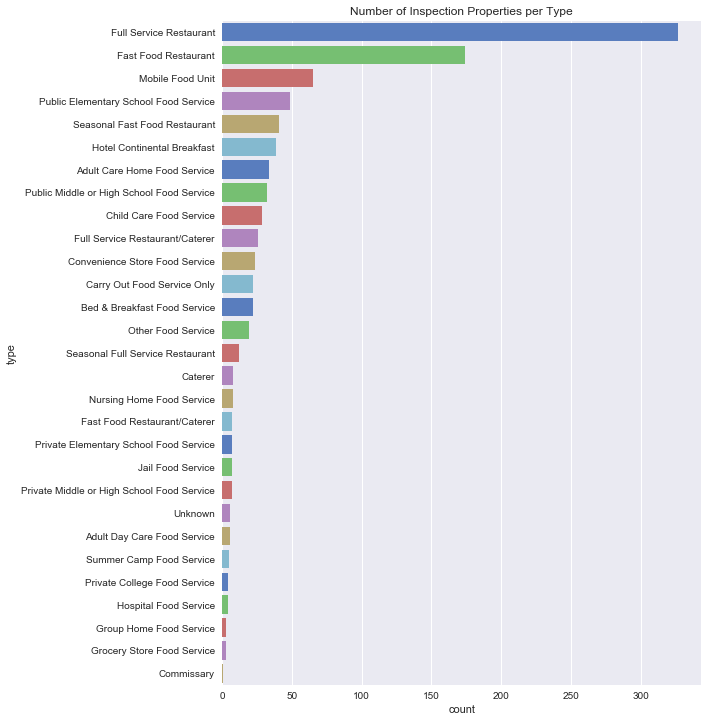

In [7]:
sns.factorplot(x='count',y='type',data=scoreByType,kind='bar',  size = 10, palette='muted')
sns.plt.title('Number of Inspected Facilities per Type')


# SCORING


## What is the distribution of inspection scores? ... encouraging

In [21]:
#sns.distplot(reduce['AvgScore'], bins=100)

group_labels = ['Average Scores']
x = [reduce['AvgScore'].astype(int)] 
fig = FF.create_distplot(x, group_labels)
iplot(fig, filename='Basic Distplot')

In [9]:
scoreByCategory= byCategory.describe().unstack()

x = scoreByCategory['AvgScore']['mean']
x.rename('AvgScore', inplace=True)

y = scoreByCategory['DerivedScore']['mean']
y.rename('DerivedScore', inplace=True)

#z = scoreByCategory['AvgScore']['count']

aggregate = pd.concat([x,y], axis=1)
aggregate = aggregate.rename_axis(None)
aggregate   # .sort_values('AvgScore', inplace=True)

,AvgScore,DerivedScore
Education,99.122516,98.942481
Government,97.336905,97.607143
Grocery,97.644243,98.038000
Hospitality,98.881899,98.772131
Medical,98.043988,98.096364
Mobile Food,99.230309,99.177692
Other,98.899123,98.986842
Restaurant,96.071380,96.251092




## What is the average inspection score for each *category*?


In [10]:
iplot(aggregate.iplot(asFigure=True,
                               kind='scatter',xTitle='Category',yTitle='Score',title='Scores per Category'))


In [11]:
scoreByCategory= byType.describe().unstack()

x = scoreByCategory['AvgScore']['mean']
x.rename('AvgScore', inplace=True)

y = scoreByCategory['DerivedScore']['mean']
y.rename('DerivedScore', inplace=True)

#z = scoreByCategory['AvgScore']['count']

aggregate = pd.concat([x,y], axis=1)
aggregate = aggregate.rename_axis(None)
aggregate  # .sort_values('AvgScore', inplace=True)

,AvgScore,DerivedScore
Adult Care Home Food Service,97.940994,97.807353
Adult Day Care Food Service,98.587798,98.616667
Bed & Breakfast Food Service,99.888528,99.890909
Carry Out Food Service Only,98.553714,98.561364
Caterer,99.002232,98.393750
Child Care Food Service,99.387325,99.198276
Commissary,100.000000,100.000000
Convenience Store Food Service,96.479741,97.364583
Fast Food Restaurant,97.134510,97.137931
Fast Food Restaurant/Caterer,98.133715,99.000000


## What is the average inspection score for each *type*?

In [12]:
layout = go.Layout(margin=go.Margin(b=200))
iplot(aggregate.iplot(asFigure=True, kind='scatter',xTitle='Category',yTitle='Score',title='Scores per Type',margin=(100,100,200,100)))


# Distribution of average scores by category.

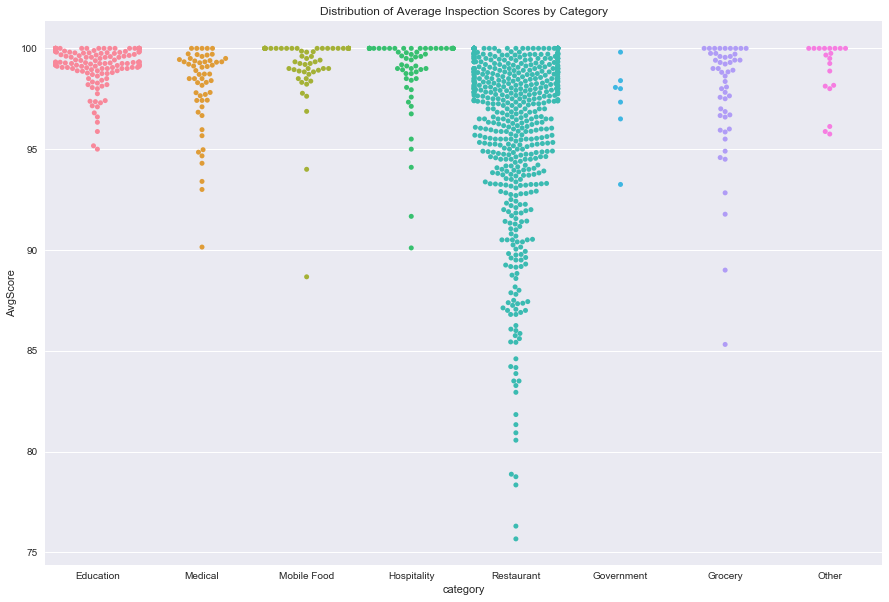

In [13]:
#sns.barplot(x="category", y='AvgScore',data=scores)
#sns.factorplot(x="category", y='AvgScore',row='score',data=scores)
#sns.factorplot(x="category", y="AvgScore",  data=scores, kind="bar");
#sns.violinplot(x="category", y="AvgScore",  data=scores);
#sns.stripplot(x="category", y="AvgScore", data=scores, jitter=True);
plt.rcParams['figure.figsize']=(15,10)
sns.swarmplot(x="category", y="AvgScore",  data=reduce, size=5)
sns.plt.title('Distribution of Average Inspection Scores by Category')

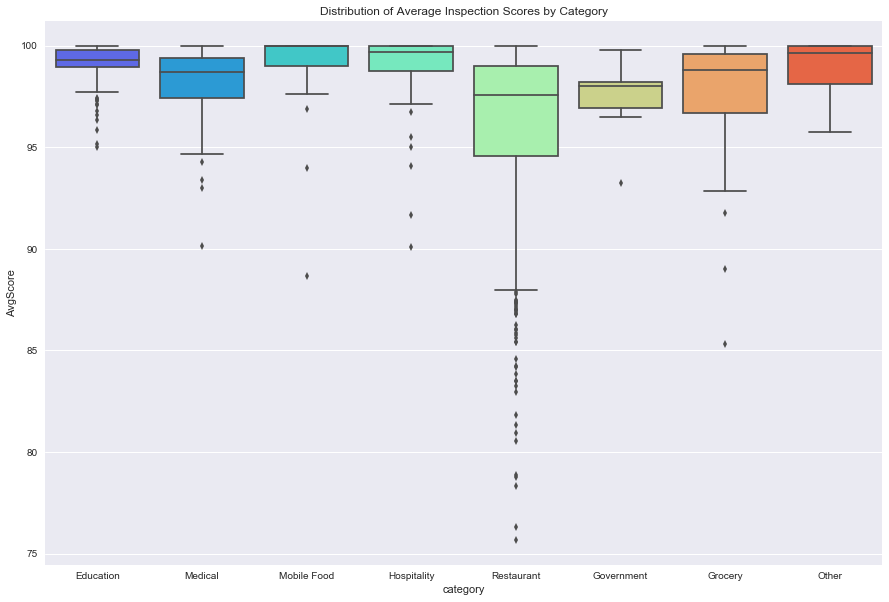

In [14]:
sns.boxplot(x="category", y="AvgScore", data=reduce, palette='rainbow')
sns.plt.title('Distribution of Average Inspection Scores by Category')

## Variance between derived score and average score.

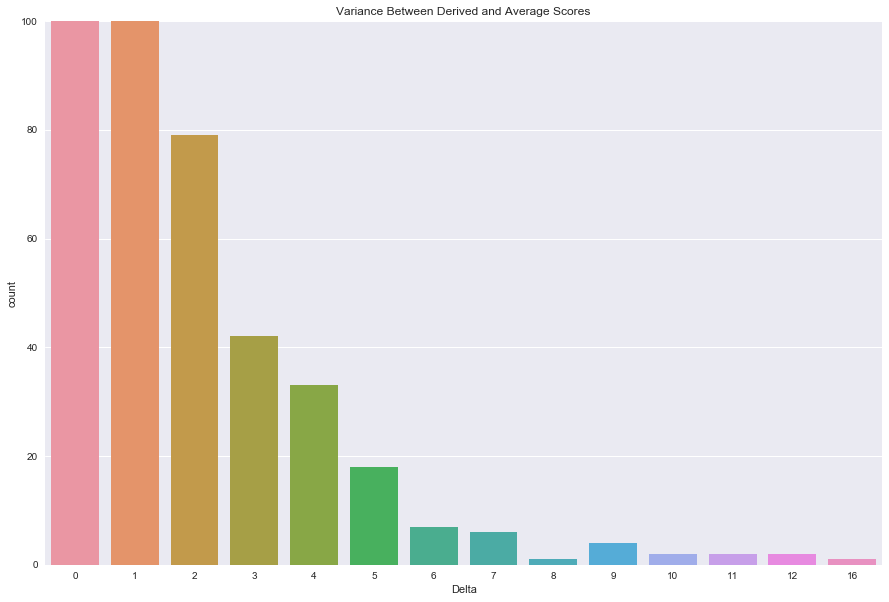

In [15]:

plt.rcParams['figure.figsize']=(15,10)
plt.ylim(0, 100)
sns.countplot(x='Delta', data=reduce )
sns.plt.title('Variance Between Derived and Average Scores')

# Relationship between number of inspections and overall score?

/Users/bcbarsness/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



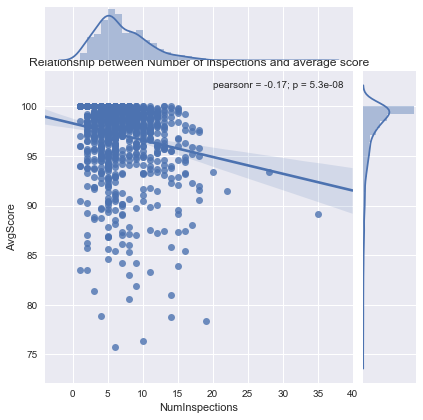

In [19]:
sns.jointplot(x='NumInspections',y='AvgScore',data=reduce,kind='reg')
sns.plt.title('Relationship between Number of inspections and average score')

# Relationship between number of inspections and overall score per category?

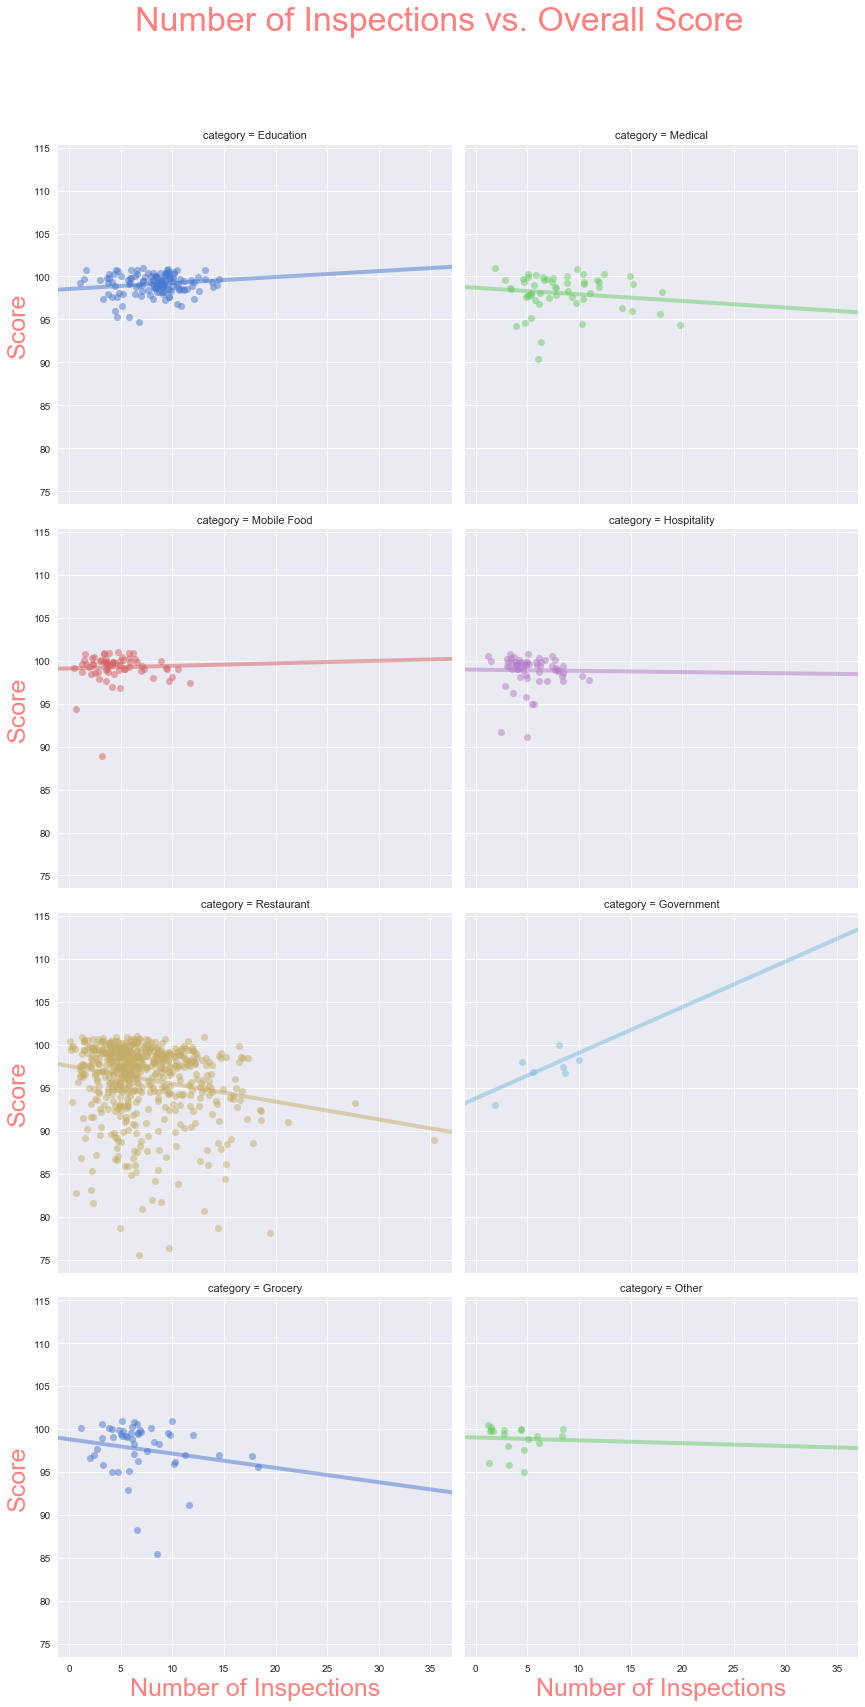

In [17]:
#sns.jointplot(x='NumInspections',y='score',data=df,kind='reg')
#sns.jointplot('NumInspections', 'score', data=df, marginal_kws=dict(bins=30, rug=True))
g = sns.lmplot(x="NumInspections", y="AvgScore",ci=None,data=reduce, col="category",
    palette="muted",col_wrap=2,scatter_kws={"s": 50,"alpha":.5},
    line_kws={"lw":4,"alpha":0.5},hue="category",x_jitter=1.0,y_jitter=1.0,size=6)

# remove the top and right line in graph
sns.despine()
# Additional line to adjust some appearance issue
plt.subplots_adjust(top=0.9)

# Set the Title of the graph from here
g.fig.suptitle('Number of Inspections vs. Overall Score', fontsize=34,color="r",alpha=0.5)

# Set the xlabel of the graph from here
g.set_xlabels("Number of Inspections",size = 25,color="r",alpha=0.5)

# Set the ylabel of the graph from here
g.set_ylabels("Score",size = 25,color="r",alpha=0.5)

# Set the ticklabel size and color of the graph from here
#titles = ['Thursday','Friday','Saturday','Sunday']
#for ax,title in zip(g.axes.flat,titles):
#    ax.tick_params(labelsize=14,labelcolor="black")

# Who had the most inspections?

In [18]:
reduce.ix[reduce['NumInspections'].idxmax()]

name              Los Potrillo's of Front Royal Inc
category                                 Restaurant
type                        Full Service Restaurant
NumInspections                                   35
DerivedScore                                   90.6
AvgScore                                    89.1765
Delta                                             1
Name: 961, dtype: object